<a href="https://colab.research.google.com/github/hanghae-plus-AI/AI-1-hyeondata/blob/main/Chapter1_2_%EA%B3%BC%EC%A0%9CA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer 실습

이번 실습에서는 감정 분석 task에 RNN 대신 Transformer를 구현하여 적용해 볼 것입니다.
Library import나 dataloader 생성은 RNN 실습 때와 똑같기 때문에 설명은 넘어가도록 하겠습니다.

In [ ]:
!pip install datasets

In [ ]:
!pip install sacremoses
# 아래 코드 실행 시 RuntimeError: Missing dependencies: sacremoses 에러가 나서 추가

In [ ]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)


ds = load_dataset("stanfordnlp/imdb")
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')


def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    labels.append(row['label'])
    texts.append(row['text'])

  texts = torch.LongTensor(tokenizer(texts, padding=True, truncation=True, max_length=max_len).input_ids)
  labels = torch.LongTensor(labels)

  return texts, labels


train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

Using cache found in C:\Users\codeKim/.cache\torch\hub\huggingface_pytorch-transformers_main


## Self-attention

이번에는 self-attention을 구현해보겠습니다.
Self-attention은 shape이 (B, S, D)인 embedding이 들어왔을 때 attention을 적용하여 새로운 representation을 만들어내는 module입니다.
여기서 B는 batch size, S는 sequence length, D는 embedding 차원입니다.
구현은 다음과 같습니다.

In [ ]:
from torch import nn
from math import sqrt


class SelfAttention(nn.Module):
  def __init__(self, input_dim, d_model):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model

    self.wq = nn.Linear(input_dim, d_model)
    self.wk = nn.Linear(input_dim, d_model)
    self.wv = nn.Linear(input_dim, d_model)
    self.dense = nn.Linear(d_model, d_model)

    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x, mask):
    q, k, v = self.wq(x), self.wk(x), self.wv(x)
    score = torch.matmul(q, k.transpose(-1, -2)) # (B, S, D) * (B, D, S) = (B, S, S)
    score = score / sqrt(self.d_model)

    if mask is not None:
      score = score + (mask * -1e9)

    score = self.softmax(score)
    result = torch.matmul(score, v)
    result = self.dense(result)

    return result

대부분은 Transformer 챕터에서 배운 수식들을 그대로 구현한 것에 불과합니다.
차이점은 `mask`의 존재여부입니다.
이전 챕터에서 우리는 가변적인 text data들에 padding token을 붙여 하나의 matrix로 만든 방법을 배웠습니다.
실제 attention 계산에서는 이를 무시해주기 위해 mask를 만들어 제공해주게 됩니다.
여기서 mask의 shape은 (B, S, 1)로, 만약 `mask[i, j] = True`이면 그 변수는 padding token에 해당한다는 뜻입니다.
이러한 값들을 무시해주는 방법은 shape이 (B, S, S)인 `score`가 있을 때(수업에서 배운 $A$와 동일) `score[i, j]`에 아주 작은 값을 더해주면 됩니다. 아주 작은 값은 예를 들어 `-1000..00 = -1e9` 같은 것이 있습니다.
이렇게 작은 값을 더해주고 나면 softmax를 거쳤을 때 0에 가까워지기 때문에 weighted sum 과정에서 padding token에 해당하는 `v` 값들을 무시할 수 있게 됩니다.

다음은 self-attention과 feed-forward layer를 구현한 모습입니다.

In [ ]:
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.dff = dff

    self.sa = SelfAttention(input_dim, d_model)
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.ReLU(),
      nn.Linear(dff, d_model)
    )

  def forward(self, x, mask):
    x = self.sa(x, mask)
    x = self.ffn(x)

    return x

보시다시피 self-attention의 구현이 어렵지, Transformer layer 하나 구현하는 것은 수업 때 다룬 그림과 크게 구분되지 않는다는 점을 알 수 있습니다.

## Positional encoding

이번에는 positional encoding을 구현합니다. Positional encoding의 식은 다음과 같습니다:
$$
\begin{align*} PE_{pos, 2i} &= \sin\left( \frac{pos}{10000^{2i/D}} \right), \\ PE_{pos, 2i+1} &= \cos\left( \frac{pos}{10000^{2i/D}} \right).\end{align*}
$$

이를 Numpy로 구현하여 PyTorch tensor로 변환한 모습은 다음과 같습니다:

In [ ]:
import numpy as np


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400
print(positional_encoding(max_len, 256).shape)

torch.Size([1, 400, 256])


Positional encoding은 `angle_rads`를 구현하는 과정에서 모두 구현이 되었습니다. 여기서 `angle_rads`의 shape은 (S, D)입니다.
우리는 일반적으로 batch로 주어지는 shape이 (B, S, D)인 tensor를 다루기 때문에 마지막에 None을 활용하여 shape을 (1, S, D)로 바꿔주게됩니다.

위에서 구현한 `TransformerLayer`와 positional encoding을 모두 합친 모습은 다음과 같습니다:

In [ ]:
class TextClassifier(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, dff):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.dff = dff

    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff) for _ in range(n_layers)])
    self.classification = nn.Linear(d_model, 1)

  def forward(self, x):
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, :]
    seq_len = x.shape[1]

    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]

    for layer in self.layers:
      x = layer(x, mask)

    x = x[:, 0]
    x = self.classification(x)

    return x


model = TextClassifier(len(tokenizer), 32, 2, 32)

기존과 다른 점들은 다음과 같습니다:
1. `nn.ModuleList`를 사용하여 여러 layer의 구현을 쉽게 하였습니다.
2. Embedding, positional encoding, transformer layer를 거치고 난 후 마지막 label을 예측하기 위해 사용한 값은 `x[:, 0]`입니다. 기존의 RNN에서는 padding token을 제외한 마지막 token에 해당하는 representation을 사용한 것과 다릅니다. 이렇게 사용할 수 있는 이유는 attention 과정을 보시면 첫 번째 token에 대한 representation은 이후의 모든 token의 영향을 받습니다. 즉, 첫 번째 token 또한 전체 문장을 대변하는 의미를 가지고 있다고 할 수 있습니다. 그래서 일반적으로 Transformer를 text 분류에 사용할 때는 이와 같은 방식으로 구현됩니다.

## 학습

학습하는 코드는 기존 실습들과 동일하기 때문에 마지막 결과만 살펴보도록 하겠습니다.

In [ ]:
from torch.optim import Adam

lr = 0.001
model = model.to('cuda')
loss_fn = nn.BCEWithLogitsLoss()

optimizer = Adam(model.parameters(), lr=lr)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    # preds = torch.argmax(preds, dim=-1)
    preds = (preds > 0).long()[..., 0]

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [ ]:
n_epochs = 50

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda').float()

    preds = model(inputs)[..., 0]
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

  with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)
    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

Epoch   0 | Train Loss: 233.09268629550934
=========> Train acc: 0.771 | Test acc: 0.740
Epoch   1 | Train Loss: 179.66826337575912
=========> Train acc: 0.836 | Test acc: 0.787
Epoch   2 | Train Loss: 149.52369917929173
=========> Train acc: 0.863 | Test acc: 0.796
Epoch   3 | Train Loss: 128.80822722613811
=========> Train acc: 0.896 | Test acc: 0.804
Epoch   4 | Train Loss: 110.14146190136671
=========> Train acc: 0.912 | Test acc: 0.804
Epoch   5 | Train Loss: 92.6625374481082
=========> Train acc: 0.934 | Test acc: 0.805
Epoch   6 | Train Loss: 75.72343704476953
=========> Train acc: 0.949 | Test acc: 0.799
Epoch   7 | Train Loss: 61.04738222807646
=========> Train acc: 0.960 | Test acc: 0.805
Epoch   8 | Train Loss: 50.54290382936597
=========> Train acc: 0.970 | Test acc: 0.803
Epoch   9 | Train Loss: 38.681776931509376
=========> Train acc: 0.980 | Test acc: 0.798
Epoch  10 | Train Loss: 31.97392925200984
=========> Train acc: 0.982 | Test acc: 0.801
Epoch  11 | Train Loss: 26.

학습이 안정적으로 진행되며 RNN보다 빨리 수렴하는 것을 확인할 수 있습니다.
하지만 test 정확도가 RNN보다 낮은 것을 보았을 때, overfitting에 취약하다는 것을 알 수 있습니다.

# 과제 A. Multi-head Attention으로 감정 분석 모델 구현하기

## Multi-head attention(MHA) 구현

### - Self-attention module을 MHA로 확장해주시면 됩니다. 여기서 MHA는 다음과 같이 구현합니다.




1. 기존의 $W_q, W_k, W_v$를 사용하여 $Q, K, V$를 생성합니다. 이 부분은 코드 수정이 필요 없습니다.
   a. $Q, K, V \in \mathbb{R}^{S \times D}$가 있을 때, 이를 $Q, K, V \in \mathbb{R}^{S \times H \times D'}$으로 reshape 해줍니다. 여기서 $H$는 n_heads라는 인자로 받아야 하고, $D$가 $H$로 나눠 떨어지는 값이여야 하는 제약 조건이 필요합니다. $D = H \times D'$입니다.
   b. $Q, K, V$를 $Q, K, V \in \mathbb{R}^{H \times S \times D'}$의 shape으로 transpose해줍니다.
2. $A = QK^T/\sqrt{D'} \in \mathbb{R}^{H \times S \times S}$를 기존의 self-attention과 똑같이 계산합니다. 이 부분은 코드 수정이 필요 없습니다.

3. Mask를 더합니다. 기존과 $A$의 shape이 달라졌기 때문에 dimension을 어떻게 맞춰줘야할지 생각해줘야 합니다.

4. $\hat{x} = \textrm{Softmax}(A)V \in \mathbb{R}^{H \times S \times D'}$를 계산해주고 transpose와 reshape을 통해 $\hat{x} \in \mathbb{R}^{S \times D}$의 shape으로 다시 만들어줍니다.

5. 기존과 똑같이 $\hat{x} = \hat{x}W_o$를 곱해줘서 마무리 해줍니다. 이 또한 코드 수정이 필요 없습니다.

In [ ]:
from torch import nn
from math import sqrt


class MultiHeadAttention(nn.Module):
  def __init__(self, input_dim, d_model,num_heads):
    super().__init__()


    assert d_model % num_heads == 0, "d_model must be divisible by num_heads" # 제약 조건 D = H * D'

    self.input_dim = input_dim
    self.d_model = d_model
    self.num_heads = num_heads    # head 개수
    self.head_dim = d_model // num_heads  # 모델 차원에서 어텐션 헤드 수 만큼 나눠서 떨어지는 값 변수

    self.wq = nn.Linear(input_dim, d_model)
    self.wk = nn.Linear(input_dim, d_model)
    self.wv = nn.Linear(input_dim, d_model)
    self.dense = nn.Linear(d_model, d_model)

    self.softmax = nn.Softmax(dim=-1)


  def forward(self, x, mask):

    batch_size, seq_length, _ = x.size()

    q = self.wq(x).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2) # (B, H, S, D')
    k = self.wk(x).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2) # (B, H, S, D')
    v = self.wv(x).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2) # (B, H, S, D')


    score = torch.matmul(q, k.transpose(-1, -2))  # (B, H, S, S)
    score = score / sqrt(self.d_model)

    if mask is not None:
      mask = mask.unsqueeze(1)
      score = score + (mask * -1e9)

    score = self.softmax(score)
    result = torch.matmul(score, v)

    result = result.transpose(1, 2).contiguous()  # (batch_size, seq_len, n_heads, depth)
    result = result.view(batch_size, -1, self.d_model)

    result = self.dense(result)

    return result

##목표

## Layer normalization, dropout, residual connection 구현

In [ ]:
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff, num_heads, dropout=0.1):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.dff = dff

    self.mha = MultiHeadAttention(input_dim, d_model, num_heads)
    self.sa = SelfAttention(input_dim, d_model)
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.ReLU(),
      nn.Linear(dff, d_model)
    )
    self.layernome = nn.LayerNorm(d_model)
    self.dropout = nn.Dropout(dropout)


  def forward(self, x, mask):
    x1 = self.mha(x, mask)
    x1 = self.dropout(x1)
    x1 = self.layernome(x1 + x)

    x2 = self.ffn(x1)
    x2 = self.dropout(x2)
    x2 = self.layernome(x2 + x1)

    return x2

## Positional encoding

In [ ]:
import numpy as np


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400
print(positional_encoding(max_len, 256).shape)

torch.Size([1, 400, 256])


In [ ]:
class TextClassifier(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, dff, n_heads):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.dff = dff

    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff, n_heads) for _ in range(n_layers)])
    self.classification = nn.Linear(d_model, 1)

  def forward(self, x):
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, :]
    seq_len = x.shape[1]

    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]

    for layer in self.layers:
      x = layer(x, mask)

    x = x[:, 0]
    x = self.classification(x)

    return x


model = TextClassifier(len(tokenizer), 32, 5, 32, 4)

## 학습

In [ ]:
from torch.optim import Adam

lr = 0.001
model = model.to('cuda')
loss_fn = nn.BCEWithLogitsLoss()

optimizer = Adam(model.parameters(), lr=lr)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    # preds = torch.argmax(preds, dim=-1)
    preds = (preds > 0).long()[..., 0]

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [ ]:
n_epochs = 50
train_acc_list = []
test_acc_list = []
for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda').float()

    preds = model(inputs)[..., 0]
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

  with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

Epoch   0 | Train Loss: 211.74170297384262
=========> Train acc: 0.811 | Test acc: 0.783
Epoch   1 | Train Loss: 142.07771268486977
=========> Train acc: 0.885 | Test acc: 0.827
Epoch   2 | Train Loss: 112.66630853712559
=========> Train acc: 0.922 | Test acc: 0.840
Epoch   3 | Train Loss: 91.68917718529701
=========> Train acc: 0.937 | Test acc: 0.830
Epoch   4 | Train Loss: 72.55480374023318
=========> Train acc: 0.955 | Test acc: 0.833
Epoch   5 | Train Loss: 52.986698573455215
=========> Train acc: 0.976 | Test acc: 0.831
Epoch   6 | Train Loss: 39.32679244317114
=========> Train acc: 0.986 | Test acc: 0.832
Epoch   7 | Train Loss: 29.766545842867345
=========> Train acc: 0.989 | Test acc: 0.830
Epoch   8 | Train Loss: 24.13745860895142
=========> Train acc: 0.992 | Test acc: 0.832
Epoch   9 | Train Loss: 18.600458627101034
=========> Train acc: 0.993 | Test acc: 0.828
Epoch  10 | Train Loss: 18.38474337523803
=========> Train acc: 0.993 | Test acc: 0.823
Epoch  11 | Train Loss: 15

### train과 test의 acc를 plot 표시

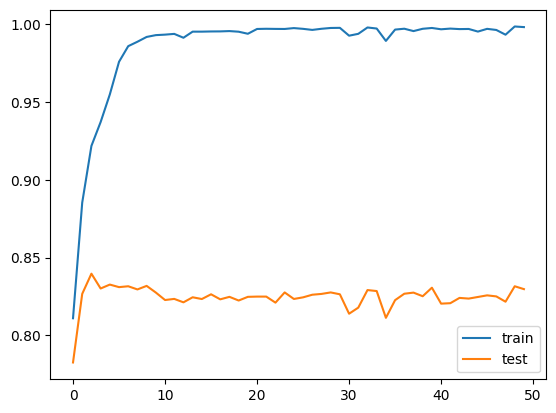

In [ ]:
import numpy as np

def plot_acc(trainloader_acc, testloader_acc, label1='train', label2='test'):
  x = np.arange(len(trainloader_acc))

  plt.plot(x, trainloader_acc, label=label1)
  plt.plot(x, testloader_acc, label=label2)
  plt.legend()
  plt.show()

# plot하는 함수 사용
plot_acc(train_acc_list, test_acc_list)

## test 성능을 높이기 위한 방안
( layer 개수 증가 5개 -> 10개 )

In [ ]:
model = TextClassifier(len(tokenizer), 32, 10, 32, 4) #layer 5개 에서 -> 10개로 증가

In [ ]:
from torch.optim import Adam

lr = 0.001
model = model.to('cuda')
loss_fn = nn.BCEWithLogitsLoss()

optimizer = Adam(model.parameters(), lr=lr)

In [ ]:
n_epochs = 50
add_layer_train_acc_list_ = []
add_layer_test_acc_list = []
for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda').float()

    preds = model(inputs)[..., 0]
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

  with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)
    add_layer_train_acc_list_.append(train_acc)
    add_layer_test_acc_list.append(test_acc)
    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

Epoch   0 | Train Loss: 204.17062270641327
=========> Train acc: 0.837 | Test acc: 0.806
Epoch   1 | Train Loss: 141.69959895312786
=========> Train acc: 0.885 | Test acc: 0.832
Epoch   2 | Train Loss: 112.32173338532448
=========> Train acc: 0.905 | Test acc: 0.826
Epoch   3 | Train Loss: 88.7713875323534
=========> Train acc: 0.947 | Test acc: 0.839
Epoch   4 | Train Loss: 69.61372296884656
=========> Train acc: 0.967 | Test acc: 0.839
Epoch   5 | Train Loss: 51.44356003589928
=========> Train acc: 0.978 | Test acc: 0.834
Epoch   6 | Train Loss: 38.42746273893863
=========> Train acc: 0.984 | Test acc: 0.832
Epoch   7 | Train Loss: 28.954081889241934
=========> Train acc: 0.989 | Test acc: 0.833
Epoch   8 | Train Loss: 26.279843483120203
=========> Train acc: 0.990 | Test acc: 0.829
Epoch   9 | Train Loss: 23.073017074726522
=========> Train acc: 0.991 | Test acc: 0.831
Epoch  10 | Train Loss: 20.564883721526712
=========> Train acc: 0.992 | Test acc: 0.833
Epoch  11 | Train Loss: 19

### train과 test의 acc를 plot 표시

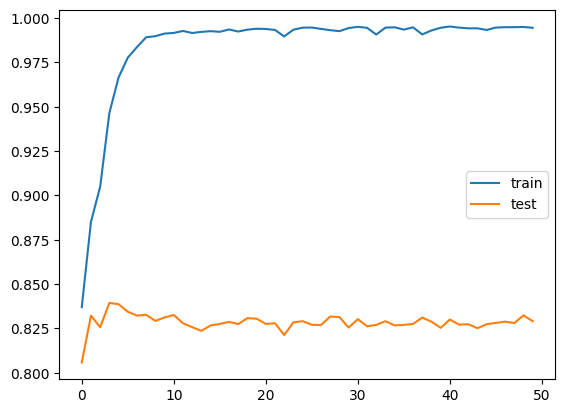

In [ ]:
import numpy as np

def plot_acc(trainloader_acc, testloader_acc, label1='train', label2='test'):
  x = np.arange(len(trainloader_acc))

  plt.plot(x, trainloader_acc, label=label1)
  plt.plot(x, testloader_acc, label=label2)
  plt.legend()
  plt.show()

# plot하는 함수 사용
plot_acc(add_layer_train_acc_list_, add_layer_test_acc_list)

## test 성능을 높이기 위한 방안
( layer 개수 증가 5개 -> 10개 )

In [ ]:
model = TextClassifier(len(tokenizer), 32, 5, 32, 8) #head 4개 에서 -> 8개로 증가

In [ ]:
from torch.optim import Adam

lr = 0.001
model = model.to('cuda')
loss_fn = nn.BCEWithLogitsLoss()

optimizer = Adam(model.parameters(), lr=lr)

In [ ]:
n_epochs = 50
add_head_train_acc_list_ = []
add_head_test_acc_list = []
for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda').float()

    preds = model(inputs)[..., 0]
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

  with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)
    add_head_train_acc_list_.append(train_acc)
    add_head_test_acc_list.append(test_acc)
    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

Epoch   0 | Train Loss: 198.89712677896023
=========> Train acc: 0.851 | Test acc: 0.816
Epoch   1 | Train Loss: 134.82814048230648
=========> Train acc: 0.900 | Test acc: 0.843
Epoch   2 | Train Loss: 104.38345185667276
=========> Train acc: 0.929 | Test acc: 0.841
Epoch   3 | Train Loss: 82.04368595778942
=========> Train acc: 0.951 | Test acc: 0.845
Epoch   4 | Train Loss: 62.39329703897238
=========> Train acc: 0.963 | Test acc: 0.842
Epoch   5 | Train Loss: 46.62835566699505
=========> Train acc: 0.981 | Test acc: 0.839
Epoch   6 | Train Loss: 32.62516516447067
=========> Train acc: 0.987 | Test acc: 0.835
Epoch   7 | Train Loss: 27.230405890382826
=========> Train acc: 0.988 | Test acc: 0.836
Epoch   8 | Train Loss: 23.281226691324264
=========> Train acc: 0.991 | Test acc: 0.833
Epoch   9 | Train Loss: 18.637436685152352
=========> Train acc: 0.992 | Test acc: 0.834
Epoch  10 | Train Loss: 18.783351919148117
=========> Train acc: 0.994 | Test acc: 0.838
Epoch  11 | Train Loss: 1

In [ ]:
add_layer_test_acc_list = add_layer_test_acc_list[:50]


### train과 test의 acc를 plot 표시

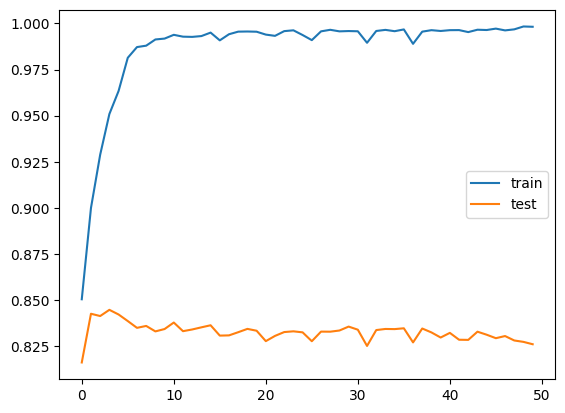

In [ ]:
import numpy as np

def plot_acc(trainloader_acc, testloader_acc, label1='train', label2='test'):
  x = np.arange(len(trainloader_acc))

  plt.plot(x, trainloader_acc, label=label1)
  plt.plot(x, testloader_acc, label=label2)
  plt.legend()
  plt.show()

# plot하는 함수 사용
plot_acc(add_head_train_acc_list_, add_head_test_acc_list)

## 모든 모델 test데이터 표시
(test 1: layer = 5, n_head = 4, test2 : layer = 10, head 4, test3 : layer = 5, head = 8)

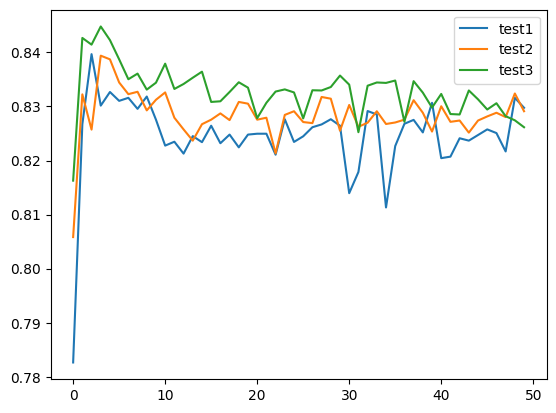

In [ ]:
import numpy as np

def plot_acc(test1, test2,test3, label1='test1', label2='test2',label3='test3'):
  x = np.arange(len(test1))

  plt.plot(x, test1, label=label1)
  plt.plot(x, test2, label=label2)
  plt.plot(x, test3, label=label3)

  plt.legend()
  plt.show()

# plot하는 함수 사용
plot_acc(test_acc_list,add_layer_test_acc_list, add_head_test_acc_list)

train1,train2,train3, 데이터는 거의 1에 근접하여 표시되는 차트가 비슷해서 표시 하지 않았고, test셋의 성능을 layer와 head의 개수에 따른 결과를 비교하기 위해 표시 했다.


## plot을 분석해본 결과
  대체적으로 head의 개수를 높이면 test셋의 일반적으로 성능이 제일 높을 것으로 추정되지만, 학습을 하면 할 수록 train데이터에 과적합 되어서 마지막에는 제일 낮은 성능을 보이고 있으며, 적절한 학습 횟수를 해야 할 것 같다.

## 추후 과제
  위의 테스트를 통해서 바꾸지 않은 학습할 때 쓰는 차원들을 변경해서 테스트가 필요할 것 같다